We visualize the trajectory of the simulation for fixed inputs with different initial conditions.

In [8]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time
import math
from perturbed_organics.spectrum_general import matrix_solution
from perturbed_organics.spectrum_general import sim_solution
import perturbed_organics.model.ORGaNICs_models as organics
import perturbed_organics.utils as utils
import numpy as np
from joblib import Parallel, delayed, parallel_backend
import argparse
import os
from matplotlib import colors
from scipy.optimize import fsolve, curve_fit
from scipy import integrate
import warnings
import shutil
import json

In [9]:
N = 100
params = {"N_y": N, "N_a": N, "eta": 0.02, "noise_type": "additive"}

b0 = 1.0 * torch.ones(N)
b1 = 1.0 * torch.ones(N)

sigma = torch.tensor([0.1])
tauA = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
tauY = 0.002 + 0 * torch.abs(torch.randn(N) * 0.001)
# Wyy = torch.eye(N)
Way = torch.ones(N, N)

In [10]:
mu = 0.0
delta = 5.0

Wyy = torch.eye(N) + utils.generate_matrix(N=N, matrix_type='goe_symmetric', s=N, mu=mu, delta=delta)

In [11]:
# define the time vector
tau_min = min(torch.min(tauA), torch.min(tauY))
tau_max= max(torch.max(tauA), torch.max(tauY))
chunk_time = 50 * tau_max  # Simulate in chunks of 50 * tau_max
dt = 0.05 * tau_min
points = int(chunk_time / dt)  # Number of points per chunk
t_chunk = torch.linspace(0, chunk_time, points)

In [12]:
# model_name = 'delocalized'
model_name = 'localized'
input_norm = 0.01
# initial_type = 'norm'
initial_type = 'zero'
# initial_type = 'first_order'

z = utils.make_input_drive(N=N, input_type=model_name, input_norm=input_norm)

model = organics.ORGaNICs2Dgeneral(
        params=params,
        b0=b0,
        b1=b1,
        sigma=sigma,
        tauA=tauA,
        tauY=tauY,
        Wyy=Wyy,
        Way=Way,
        z=z,
        run_jacobian=False
    )

In [ ]:
def is_fixed_point(trajectory, window=100, tol=1e-5):
    """
    Check if the trajectory has converged to a fixed point.
    Args:
        trajectory (torch.Tensor): Shape (time_steps, state_dim)
        window (int): Number of recent points to analyze
        tol (float): Tolerance for detecting fixed points
    Returns:
        bool: True if the trajectory is at a fixed point
    """
    if len(trajectory) < window:
        return False
    last_window = trajectory[-window:]  # Shape (window, state_dim)
    diffs = torch.abs(last_window[1:] - last_window[:-1])  # Shape (window-1, state_dim)
    max_diff = torch.max(diffs)
    return max_diff < tol

def is_oscillatory(trajectory, window=100, tol=1e-5):
    """
    Check if the trajectory is oscillatory in any dimension.
    Args:
        trajectory (torch.Tensor): Shape (time_steps, state_dim)
        window (int): Number of recent points to analyze
        tol (float): Tolerance for detecting oscillations
    Returns:
        bool: True if the trajectory exhibits oscillations
    """
    if len(trajectory) < window:
        return False
    last_window = trajectory[-window:]  # Shape (window, state_dim)
    ranges = torch.max(last_window, dim=0)[0] - torch.min(last_window, dim=0)[0]  # Shape (state_dim,)
    return torch.any(ranges > tol)

def is_diverging(trajectory, max_val=1e10):
    """
    Check if the trajectory is diverging (NaNs or excessively large values).
    Args:
        trajectory (torch.Tensor): Shape (time_steps, state_dim)
        max_val (float): Threshold for detecting divergence
    Returns:
        bool: True if the trajectory is diverging
    """
    return torch.any(torch.isnan(trajectory)) or torch.any(torch.abs(trajectory) > max_val)

In [7]:
y0 = model.inital_conditions(initial_type=initial_type)

sim_obj = sim_solution(model)
sim = sim_obj.simulate(t, y0=y0)

NameError: name 't' is not defined

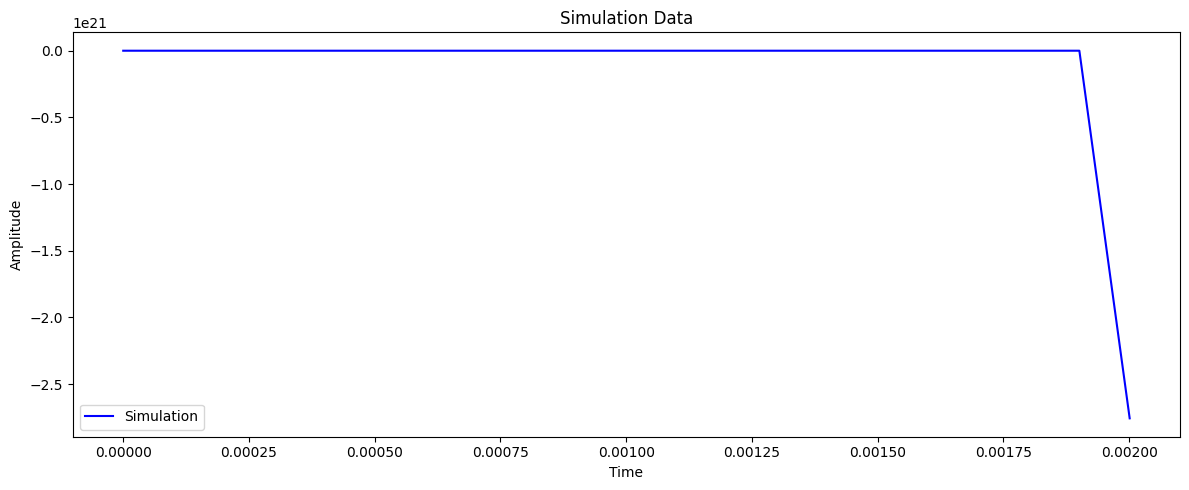

In [77]:
# Assume idx, t, sim, z_func, model.kwargs are already defined
idx = 0

# Create a figure with one subplot
fig, ax = plt.subplots(figsize=(12, 5))

# Plot the simulation data
ax.plot(t, sim[:, idx].detach().numpy(), label='Simulation', color='blue')
ax.set_title('Simulation Data')
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
ax.legend()
# ax.grid(True)

plt.tight_layout()
plt.show()

In [79]:
sim

tensor([[ 0.6552, -0.0626,  0.4986,  ...,  0.0112,  0.0112,  0.0112],
        [ 1.1187, -0.1206,  0.5445,  ...,  0.0164,  0.0164,  0.0164],
        [ 1.5873, -0.1876,  0.6193,  ...,  0.0249,  0.0249,  0.0249],
        ...,
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [    nan,     nan,     nan,  ...,     nan,     nan,     nan]])

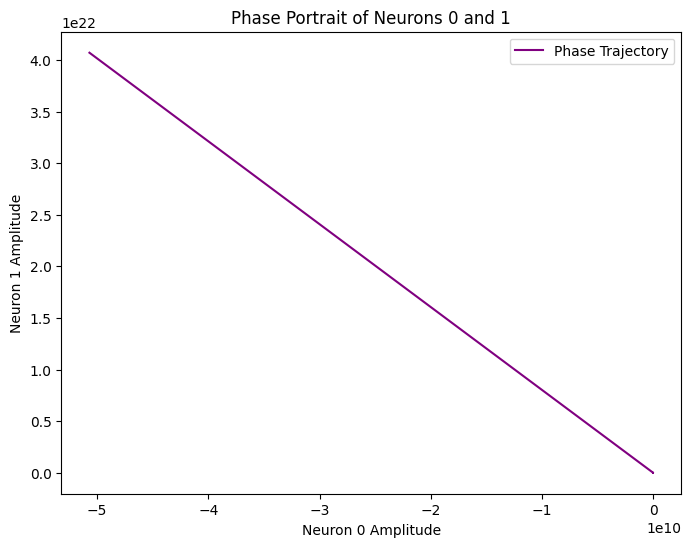

In [78]:
# Extract the simulation data for neurons 0 and 1
sim_neuron0 = sim[:, idx].detach().numpy()
sim_neuron1 = sim[:, idx + 101].detach().numpy()

# Create the phase portrait plot
plt.figure(figsize=(8, 6))
plt.plot(sim_neuron0, sim_neuron1, label='Phase Trajectory', color='purple')
plt.xlabel('Neuron 0 Amplitude')
plt.ylabel('Neuron 1 Amplitude')
plt.title('Phase Portrait of Neurons 0 and 1')
plt.legend()
# plt.grid(True)
plt.show()